In [ ]:
!git clone https://github.com/santialferez/mlmae.git

cd mlmae

# Ejemplo de regresión multi-output con MLP 

### Objetivos

Este ejemplo que he realizado muestra dos cosas importantes:

 1. Cómo construir un custom `Dataset`, a partir de un dataset algo genérico y a partir de ahí utilizar todo el mecanismo de `Dataloader` de PyTorch
 
 2. Cómo realizar una regresión multi-output (varias salidas) usando una MLP.
 
 Este es un ejemplo, no para solucionar de forma excelente el problema, sino para ilustrar los diferentes procesos. El modelo final no es muy bueno, porque nos encontramos en la limitación de usar sólo MLP para imágenes, cuando por ejemplo las redes neuronales convolucionales (CNN) son muchísimo mejor para trabajar con imágenes.

La mayoría de problemas que trabajaran en sus proyectos lo podrán solucionar fácilmente de dos formas:
- Involucrando `torch.utils.data.TensorDataset()` para convertir un conjunto de tensores en un Dataset (ver notebook de ejemplo de la regresión logística.
- Si trabajan con imágenes y organizan las clases por carpetas pueden usar `torchvision.datasets.ImageFolder()`. En este [link](https://pytorch.org/vision/stable/datasets.html#torchvision.datasets.ImageFolder) está su documentación.

Sin embargo, el ejemplo a continuación, lo realizo para un caso más complejo (de regresión multi-output) que no se encuentra fácilmente en los tutoriales o en foros.

In [ ]:
#Imports

import numpy as np
from torch import nn, optim
import torch
import torch.nn.functional as F

from torch.utils.data import Dataset
from torch.utils.data import DataLoader

from torchvision import datasets
from torchvision.transforms import ToTensor
from torchvision import transforms

import os
import glob
from torchvision.io import read_image

import matplotlib.pyplot as plt
%matplotlib inline

### Dataset

Vamos a trabajar con un dataset de Gatos, en donde se han anotados diferentes puntos de los gatos. El dataset completo (pesa unas 4GB) se encuentra en https://www.kaggle.com/crawford/cat-dataset. 

Dado que el propósito de este ejemplo es más didactico he tomado sólamente una carpeta del dataset `CAT_03` (la que menos imágenes tiene) cómo conjunto de entrenamiento y una parte muy reducida de la carpeta `CAT_041` como conjunto de validación. 

En cada carpeta se encuentra un conjuntos de imágenes de gatos, con un archivo de texto correspondiente de tal forma que se describe el número de puntos y las coordenadas `(x,y)` de hasta 9 puntos del gato. La descripción completa (tomada de la web anterior) es:

- Number of points (default is 9)
- Left Eye
- Right Eye
- Mouth
- Left Ear-1
- Left Ear-2
- Left Ear-3
- Right Ear-1
- Right Ear-2
- Right Ear-3

Los nombres de los archivos se encuentran asociados así: si el nombre de la imagen es `cat1.jpg`, el nombre del archivo de texto es `cat1.jpg.cat`. 

Nos centraremos en sólo la posición de la boca (mouth).

### Una imagen, el punto de la boca y ¿qué sucede si se reescala la imagen?

Miremos una imagen y la posición de la boca del gato para esa imagen (recordemos que están en coordenadas `(x,y)`)

In [ ]:
train_dir = "dat/CAT_03/"

images = glob.glob(os.path.join(train_dir,'*.jpg'))

anot0_file = images[1] + '.cat'
anot0_file

'dat/CAT_03/00000804_003.jpg.cat'

In [ ]:
anot0 = np.genfromtxt(anot0_file)
mouth = anot0[5:7]
mouth

array([161., 298.])

Es importante notar, que el formato `(x,y)` del punto corresponde en la imagen a  `(columna, fila)` (pero matplotlib grafica así).

In [ ]:
cat0 = read_image(images[1])
cat0.shape

torch.Size([3, 500, 370])

La imagen tiene dimensiones de `(3, altura, ancho)`, contrario a formatos típicos como en nump, skcikit-image, porque en python, la primera dimensión son los canales (o el índice del dato).  Ahora visualicemos la imagen y el punto:

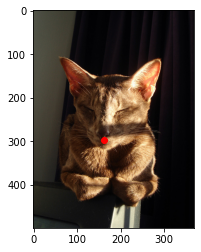

In [ ]:
plt.imshow(cat0.permute(1,2,0))
plt.plot(mouth[0],mouth[1],'or');

Algo muy importante, es que para este dataset las imágenes tienen tamaños diferentes. Para poder trabajar con ellas, la gran mayoría de las veces (un ejemplo de excepción, es usar histogramas normalizados como vectores de características) se necesita cambiar el tamaño de todas las imágenes a un tamaño igual y constante. En nuestro caso, con el objeto de "aplanar" la imagen y obtener siempre el mismo número de características. 

Veámos que sucede si re-escalamos la imagen a un tamaño de `100 x 100`:

In [ ]:
resize = transforms.Resize(size=(100,100))

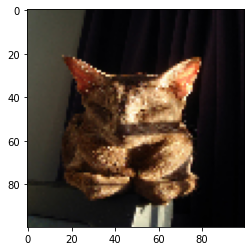

In [ ]:
plt.imshow(resize(cat0).permute(1,2,0))

Claramente se deforma, pero mantenemos un tamaño igual para todas las imágenes. Si la imagen se escala el punto de la boca también debería escalarse por un factor proporcional. Para esto, basta dividir cada coordenada, por el valor correspondiente de la dimensión de la imagen de cada eje. Luego, simplemente dividimos el vector del punto por éste vector de reescalamiento.

In [ ]:
dy, dx = cat0.shape[1]/100, cat0.shape[2]/100

In [ ]:
new_mouth = np.round(mouth/np.array([dx,dy]))

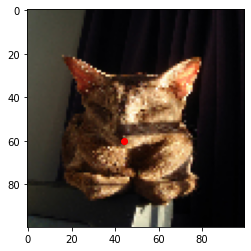

In [ ]:
plt.imshow(transforms.Resize(size=(100,100))(cat0).permute(1,2,0))
plt.plot(new_mouth[0],new_mouth[1], 'or')

Así, logramos colocar el punto de la boca en la posición correcta, luego de re-escalar la imagen.

### Custom dataset para leer imagen y punto de la boca del gato

El código para procesar muestras de datos puede resultar complicado y difícil de mantener; idealmente queremos que nuestro código para manejar el conjunto de datos se desacople de nuestro código para el entrenamiento del modelo con el fin de una mejor legibilidad y modularidad. PyTorch proporciona dos clases primitivas: `torch.utils.data.DataLoader` y` torch.utils.data.Dataset` que le permiten utilizar conjuntos de datos precargados, así como sus propios datos. `Dataset` almacena las muestras y sus etiquetas correspondientes, y `DataLoader` envuelve un iterable alrededor del conjunto de datos para permitir un fácil acceso a las muestras.

`Dataset`es una clase abstracta que representa un conjunto de datos. El custom dataset debe heredar de `Dataset` y sobreescribir los siguientes métodos:


- `__len__` so that len(dataset) returns the size of the dataset.
- `__getitem__` to support the indexing such that `dataset[i]` can be used to get iith sample.

- `__len__` para que `len(dataset)` devuelva el tamaño del conjunto de datos.
- `__getitem__` para admitir la indexación de modo que el `dataset[i]` pueda usarse para obtener la i-ésima muestra.

La siguiente clase hace uso de lo desarrollado en la sección anterior, uniendo todo el proceso desde la lectura de los archivos y el reescalamiento. Particularmente, los `Dataset` tienen otra forma más estándar de manejar las transformaciones (`Transforms`), pero normalmente lo hacen para la imagen, como para la etiqueta de forma separada. Por eso, no seguí esta forma estándar, sino involucre el proceso de transformación imagen y punto (que está ligado) en una sóla función (o método).

Recomiendo estos dos tutoriales sobre como hacer custom datasets:
- https://pytorch.org/tutorials/beginner/basics/data_tutorial.html
- https://pytorch.org/tutorials/beginner/data_loading_tutorial.html

In [ ]:
class CustomImageDataset(Dataset):
    def __init__(self,img_dir,resizes=None):
        self.img_dir = img_dir
        self.resizes = resizes #Tupla (altura, ancho) del tamaño resultante de re-escalar la imagen
        self.list_img = glob.glob(os.path.join(img_dir,'*.jpg')) # lista de los archivos de sólo la imágenes       
        
    def __len__(self):
        return len(self.list_img)
    
    def transform(self, image, y):
        # Re-escalamiento de las coordenadas del punto según el re-escalamiento de la imagen
        dy, dx = image.shape[1]/self.resizes[0], image.shape[2]/self.resizes[1]
        y = np.round(y/np.array([dx,dy]))        
        
        resize = transforms.Resize(size=self.resizes) #instancia el re-rescalamiento
        image = resize(image) #ejecuta el re-escalamiento
        return image/255, torch.tensor(y).float() #para que tambien sea y un torch.tensor. y el image/255 es para normalizar el tensor entre 0 y 1 (y sea float)      
    
    def __getitem__(self,idx):
        image = read_image(self.list_img[idx]) # con read_image la imagen se lee ya como tensor
        anot_file = self.list_img[idx] + '.cat' # archivo de las anotaciones
        y = np.genfromtxt(anot_file)[5:7] # leyendo solo las coordenadas de la boca
        if self.resizes:
            image, y = self.transform(image, y) 
        return image, y    

A continuación, creamos una función para graficar las imágenes con matplotlib y las coordenadas de la boca.

In [ ]:
def plot_cat(img,mouth):
    plt.imshow(img.permute(1,2,0)) # paso necesario debido al formato de las imágenes en pytorch
    plt.plot(mouth[0],mouth[1],'or')

### Creando los datasets para entrenamiento y validación (y también los dataloaders)

In [ ]:
##########################
### CONFIGURACION
##########################

RANDOM_SEED = 123
NUM_EPOCHS = 100
DEVICE = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
lr = 0.01
RS = 20 # escalamiento de todas la imagenes a RS x RS
BS = 1024

torch.manual_seed(RANDOM_SEED);

inicialmente re-escalaremos todas las imágenes a `RS x RS` para simplificar el número de pixeles y por ende de características de entrada. A continuación, instanciaremos el dataset de training.

In [ ]:
train_ds = CustomImageDataset(train_dir, resizes=(RS,RS))

In [ ]:
img,y = train_ds[34] # un gato específico

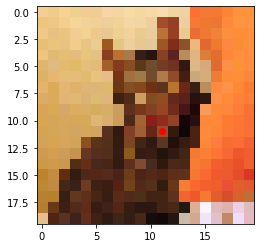

In [ ]:
plot_cat(img,y) # grafica el gato  y el punto de la boca

#### Iterando a través del DataLoader
Construyamos el `DataLoader`a partir del `Dataset`para un batch específico y revolviéndolos aleatoriamente

In [ ]:
train_dl = DataLoader(train_ds, batch_size=BS, shuffle=True, )

In [ ]:
img, y = next(iter(train_dl))
print(f"image batch size: {img.size()}")
print(f"mouth batch size: {y.size()}")

image batch size: torch.Size([811, 3, 20, 20])
mouth batch size: torch.Size([811, 2])


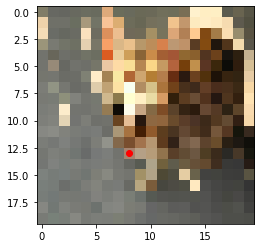

In [ ]:
plot_cat(img[8],y[8])

Ahora construyamos un `Dataset`y un `DataLoader`para el conjunto de validación

In [ ]:
valid_ds = CustomImageDataset(train_dir, resizes=(RS,RS))
valid_dl = DataLoader(valid_ds, batch_size=BS*2)

## Entrenando un MLP

A partir de ahora vamos a construir una red neuronal artificial de tipo multilayer perceptron (MLP) con sólo una capa oculta (de 100 neuronas). Es importante fijarse, que la cantidad de características corresponde al número de pixeles totales de la imagen a color, es decir, `RS*RS*3`.

In [ ]:
model = nn.Sequential(
    nn.Linear(RS*RS*3,500),
    nn.Dropout(p=0.15),
    nn.ReLU(),
    nn.Linear(500, 2)
)

Fijémonos que la capa de salida posee sólo dos neuronas, sin ninguna función de activación, ya que es un problema de regresión.

La función de costo, es la misma que para cualquier regresión. Esto sucede porque en realidad cuando existe múltiples variables respuesta, `mse_loss` calcula el *MSE* para cada variable de salida y luego los promedia.

Algo importante, es que he usado una capa denominada `Dropout`, que consiste en anular (volver cero las activaciones) de una proporción `p` (aleatoria) de neuronas de la capa anterior (para un poco de más detalle ver [este link](https://www.educative.io/edpresso/what-is-dropout-in-neural-networks)). 

In [ ]:
loss_func = F.mse_loss
model = model.to(DEVICE)
opt = optim.RMSprop(model.parameters(),lr = lr, momentum=0.9)

scheduler = optim.lr_scheduler.OneCycleLR(
    opt, max_lr=0.01, steps_per_epoch=len(train_dl), epochs=NUM_EPOCHS)

Observemos que hemos utilizado una variación del SGD denominada RMSprop (de las muchas que hay).  

La siguiente función, es para calcular el loss a un minibatch convirtiendo la imagen a un vector de características (es decir aplanandola). Recomiendo enormemente la lectura de [este blog](https://ruder.io/optimizing-gradient-descent/) (hecho por Sebastian Ruder) que explica muy bien los diferentes tipos de optimizadores.

También podemos involucrar la regularización tipo L2 usando el parámetro `weight_decay` del optimizador.

Vamos a emplear también lo que se denomina un *Schedule* sobre el learning rate (LR). Esto es un control sobre los valores del LR que busca acelerar el aprendizaje, buscar el mejor modelo, evitar atascos en mínimos muy locales, etc. Particularmente, usamos el OneCycleLR. Más información sobre diversos schedules pueden encontrarlo en [este link](https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate).

In [ ]:
def loss_batch(xb,yb):
    yp = model(xb.view(-1, RS*RS*3).to(DEVICE)) # Se reforma la imagen a un vector columna
    yt = yb.to(DEVICE)
    loss = loss_func(yp, yt)
    out = [loss, len(xb)]
    return out

Y realizamos el típico método `train` .

In [ ]:
def train():
    
    train_losses = []
    valid_losses = []
    for epoch in range(NUM_EPOCHS):
        model.train()
        losses = 0
        nums = 0
        for xb, yb in train_dl:
            loss, l = loss_batch(xb,yb)
            loss.backward()
            opt.step()
            opt.zero_grad()
            
            losses += loss.item() * l
            nums += l
            scheduler.step()
        train_loss = losses / nums
        train_losses.append(train_loss)
        
        model.eval()
        with torch.no_grad():
            losses, nums = zip(*[loss_batch(xb, yb) for xb, yb in valid_dl])
        losses = [l.item() for l in losses]
        valid_loss = np.sum(np.multiply(losses,nums)) / np.sum(nums)
        valid_losses.append(valid_loss)
              
        if epoch % 5 == 0:
            print(f"epoch: {epoch},    train_loss: {train_loss:.4f} \
            valid_loss: {valid_loss:.4f}")
    
    plt.plot(range(NUM_EPOCHS), train_losses, 'r', label='train')
    plt.plot(range(NUM_EPOCHS), valid_losses, 'b', label = 'valid')
    plt.legend()

epoch: 0,    train_loss: 111.4223             valid_loss: 15.4046
epoch: 5,    train_loss: 38.3096             valid_loss: 16.4153
epoch: 10,    train_loss: 54.4394             valid_loss: 30.5642
epoch: 15,    train_loss: 20.8051             valid_loss: 22.4970
epoch: 20,    train_loss: 15.8065             valid_loss: 13.0248
epoch: 25,    train_loss: 40.0823             valid_loss: 322.5819
epoch: 30,    train_loss: 95.4959             valid_loss: 93.6699
epoch: 35,    train_loss: 82.4818             valid_loss: 55.3082
epoch: 40,    train_loss: 39.7838             valid_loss: 13.8490
epoch: 45,    train_loss: 31.5147             valid_loss: 18.2515
epoch: 50,    train_loss: 19.2653             valid_loss: 21.2655
epoch: 55,    train_loss: 17.3308             valid_loss: 10.6084
epoch: 60,    train_loss: 13.7346             valid_loss: 10.2505
epoch: 65,    train_loss: 14.6016             valid_loss: 11.6964
epoch: 70,    train_loss: 13.9118             valid_loss: 9.8243
epoch: 75, 

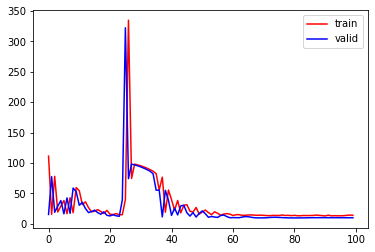

In [ ]:
train()

In [ ]:
ypred = model(img.view(-1, RS*RS*3).to(DEVICE))
ypred

tensor([[ 8.0766,  8.7475],
        [10.0127, 10.6203],
        [ 7.9900,  8.3850],
        ...,
        [ 9.2443,  9.7694],
        [11.0830, 11.7987],
        [10.4411, 11.0958]], device='cuda:0', grad_fn=<AddmmBackward>)

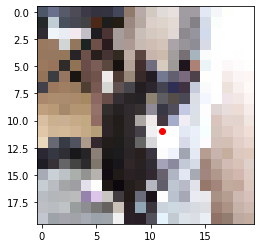

In [ ]:
i = 23
plot_cat(img[i],y[i])

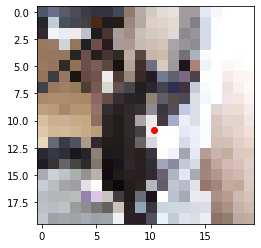

In [ ]:
plot_cat(img[i],ypred[i].detach().cpu().numpy())

## Producción: exportando el modelo para inferencia (predicción)

La forma más recomendada es usar `state_dict` para guardar sólo los pesos. Es decir, que cuando se cargue el modelo primero hay que instanciar el modelo y luego cargarle los pesos. Veámos

In [ ]:
torch.save(model.state_dict(), "model_mouthcat_weights.pth")

Con esto hemos salvado los pesos del modelo. Ahora realicemos la inferencia, construyendo el modelo ,cargandole los pesos y llevandolo a la cpu (es mejor hacer inferencia sobre cpu).

In [ ]:
modelp = nn.Sequential(
    nn.Linear(RS*RS*3,500),
    nn.Dropout(p=0.15),
    nn.ReLU(),
    nn.Linear(500, 2)
)

In [ ]:
modelp.load_state_dict( torch.load("model_mouthcat_weights.pth", map_location=torch.device('cpu')) )
modelp.eval()

Sequential(
  (0): Linear(in_features=1200, out_features=500, bias=True)
  (1): Dropout(p=0.15, inplace=False)
  (2): ReLU()
  (3): Linear(in_features=500, out_features=2, bias=True)
)

Ahora leamos una imagen y realicemos la predicción:

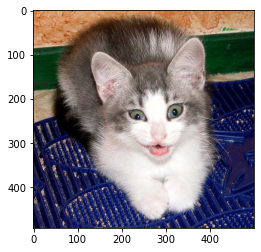

In [ ]:
im_path = "dat/CAT_04_sample/00000900_029.jpg"

im = read_image(im_path)
plt.imshow(im.permute(1,2,0));

In [ ]:
im_r = transforms.Resize(size=(RS,RS))(im)/255 # re-escalamos y normalizamos (para convertir a float entre 0y1)

with torch.no_grad():
    ypred = modelp(im_r.view(-1, RS*RS*3)) # hacemos la prediccion
ypred

tensor([[10.9918, 11.6991]])

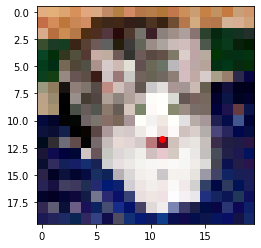

In [ ]:
plot_cat(im_r, ypred[0])